# ***Proiect SI***
# ***Predicția probabilității anulării unei rezervări***

# I. Introducere


***1. Bibliotecile incluse***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
%matplotlib inline
from google.colab import drive
import os
from google.colab import files
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score




***2. Citirea și încărcarea setului de date***

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'SI_PROIECT'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/SI_PROIECT/{}'.format(FOLDERNAME))
%cd drive/MyDrive/SI_PROIECT


Mounted at /content/drive
/content/drive/MyDrive/SI_PROIECT


In [3]:
import pandas as pd
data = None

data = pd.read_csv('hotel_bookings.csv', delimiter=';')

data.head(500)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0,0,0,Check-Out,01.07.2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0,0,0,Check-Out,01.07.2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75,0,0,Check-Out,02.07.2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75,0,0,Check-Out,02.07.2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98,0,1,Check-Out,03.07.2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Resort Hotel,0,92,2015,July,29,17,1,2,2,...,No Deposit,240.0,NaN,0,Transient,1035,1,3,Check-Out,20.07.2015
496,Resort Hotel,0,91,2015,July,29,17,1,2,2,...,No Deposit,240.0,NaN,0,Transient,1185,0,3,Check-Out,20.07.2015
497,Resort Hotel,0,38,2015,July,29,17,1,2,2,...,No Deposit,240.0,NaN,0,Transient,192,0,1,Check-Out,20.07.2015
498,Resort Hotel,0,6,2015,July,29,17,1,2,2,...,No Deposit,142.0,NaN,0,Contract,12827,0,0,Check-Out,20.07.2015


***3. Descrierea setului de date***

Acest set de date conține informații despre rezervările hotelurilor, fiind ideal pentru explorarea întrebărilor legate de momentul optim pentru a rezerva o cameră de hotel sau pentru a determina probabilitatea anulării unei rezervări. Setul de date include detalii precum data rezervării, durata șederii, numărul de adulți, copii și bebeluși, și numărul de locuri de parcare disponibile, printre altele. Toate informațiile de identificare personală au fost eliminate din date.

***4. Informații despre setul de date***

In [4]:
print("Numar de linii: ",data.shape[0])
print("Numar de coloane: ",data.shape[1])

Numar de linii:  119390
Numar de coloane:  32


*Setul de date conține atât date numerice, cât și categorice, oferind o oportunitate excelentă pentru analiză exploratorie și modelare predictivă.*

*  hotel - Tipul hotelului (H1 = Resort Hotel sau H2 = City Hotel).
*  is_canceled - Valoare care indică dacă rezervarea a fost anulată (1) sau nu (0).
*  lead_time - Numărul de zile dintre data rezervării și data sosirii.
*  arrival_date_year - Anul sosirii.
*  arrival_date_month - Luna sosirii.
*  arrival_date_week_number - Numărul săptămânii din an pentru data sosirii.
*  arrival_date_day_of_month - Ziua lunii pentru data sosirii.
*  stays_in_weekend_nights - Numărul de nopți de weekend (sâmbătă sau duminică) petrecute sau rezervate la hotel.
*  stays_in_week_nights - Numărul de nopți din timpul săptămânii (luni până vineri) petrecute sau rezervate la hotel.
*  adults - Numărul de adulți.
*  children - Numărul de copii.
*  babies - Numărul de bebeluși.
*  meal - Tipul de masă rezervată. Categoriile sunt prezentate în pachetele standard de ospitalitate: Undefined/SC – fără pachet de masă; BB – Bed & Breakfast; HB – Half board (mic dejun și încă o masă – de obicei cină); FB – Full board (mic dejun, prânz și cină).
*  country - Țara de origine. Categoriile sunt reprezentate în formatul ISO 3155–3:2013.
*  market_segment - Segmentul de piață al rezervării. În categorii, termenul “TA” înseamnă “Travel Agents” și “TO” înseamnă “Tour Operators”.
*  distribution_channel - Canalul de distribuție al rezervării. Termenul “TA” înseamnă “Travel Agents” și “TO” înseamnă “Tour Operators”.
*  is_repeated_guest - Valoare care indică dacă rezervarea a fost făcută de un client care a mai fost la hotel (1) sau nu (0).
*  previous_cancellations - Numărul de rezervări anterioare care au fost anulate de client înainte de rezervarea curentă.
*  previous_bookings_not_canceled - Numărul de rezervări anterioare care nu au fost anulate de client înainte de rezervarea curentă.
*  reserved_room_type - Codul tipului de cameră rezervată. Codul este prezentat în locul denumirii pentru motive de anonimat.
*  assigned_room_type - Codul tipului de cameră atribuit rezervării. Uneori, tipul de cameră atribuit diferă de cel rezervat din motive operaționale (de exemplu, suprasolicitare) sau la cererea clientului. Codul este prezentat în locul denumirii pentru motive de anonimat.
*  booking_changes - Numărul de modificări/amendamente făcute rezervării din momentul înregistrării până la momentul check-in-ului sau anulării.
*  deposit_type - Indică dacă clientul a făcut un depozit pentru a garanta rezervarea. Această variabilă poate avea trei categorii: No Deposit – nu s-a făcut niciun depozit; Non Refund – s-a făcut un depozit în valoarea totală a sejurului; Refundable – s-a făcut un depozit sub valoarea totală a sejurului.
*  agent - ID-ul agenției de turism care a făcut rezervarea.
*  company - ID-ul companiei/entității care a făcut rezervarea sau care este responsabilă pentru plata rezervării. ID-ul este prezentat în locul denumirii pentru motive de anonimat.
*  days_in_waiting_list - Numărul de zile în care rezervarea a fost pe lista de așteptare înainte de a fi confirmată clientului.
*  customer_type - Tipul rezervării, cu una din cele patru categorii: Contract - când rezervarea are un alocare sau alt tip de contract asociat; Group – când rezervarea este asociată unui grup; Transient – când rezervarea nu face parte dintr-un grup sau contract și nu este asociată altor rezervări tranzitorii; Transient-party – când rezervarea este tranzitorie, dar este asociată cel puțin unei alte rezervări tranzitorii.
*  adr - Tariful mediu zilnic definit prin împărțirea sumei totale a tranzacțiilor de cazare la numărul total de nopți de ședere.
*  required_car_parking_spaces - Numărul de locuri de parcare necesare pentru client.
*  total_of_special_requests - Numărul de cereri speciale făcute de client (de exemplu, pat twin sau etaj superior).
*  reservation_status - Ultimul statut al rezervării, cu una din cele trei categorii: Canceled – rezervarea a fost anulată de client; Check-Out – clientul a făcut check-in dar a plecat deja; No-Show – clientul nu a făcut check-in și nu a informat hotelul despre motivul absenței.
*  reservation_status_date - Data la care ultimul statut a fost setat. Această variabilă poate fi utilizată împreună cu ReservationStatus pentru a analiza schimbările de statut.









# II. Vizualizarea datelor


***1. Histograme pentru vizualizarea datelor***






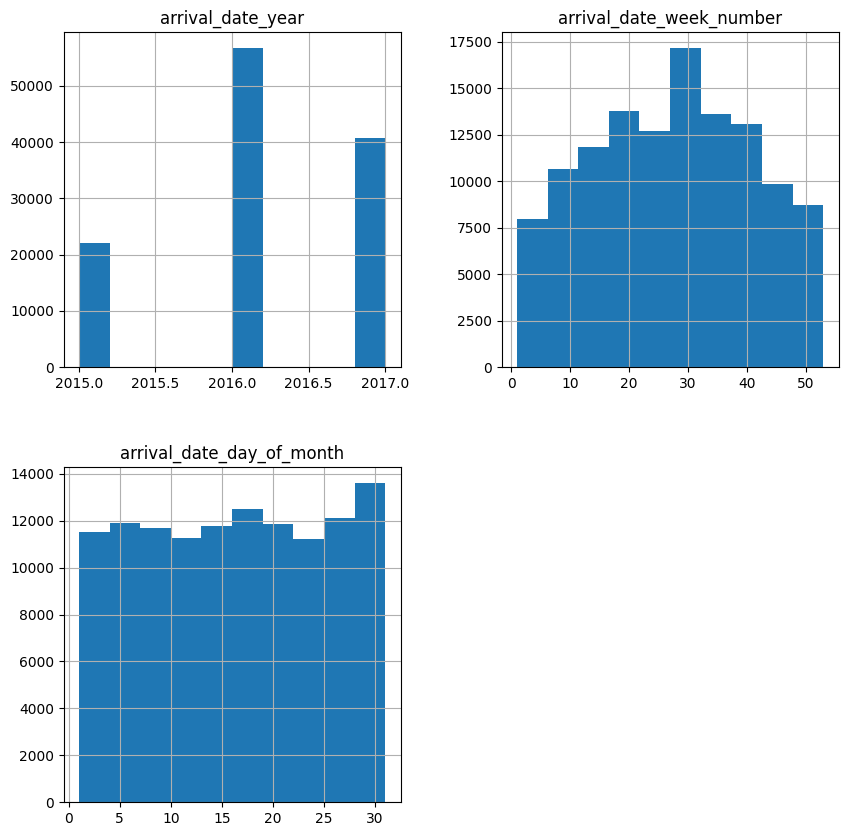

In [5]:
arrivals = data[['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month']].copy()

arrivals.hist(bins = 10, figsize=(10,10))
plt.show()

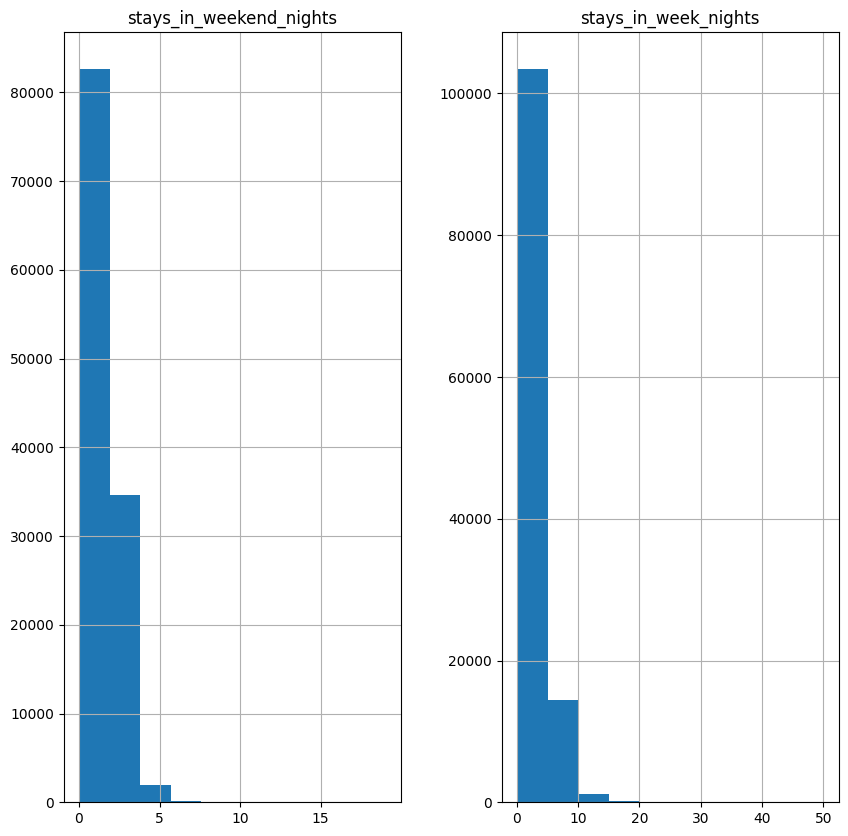

In [6]:
stays = data[['stays_in_weekend_nights', 'stays_in_week_nights']].copy()

stays.hist(bins = 10, figsize=(10,10))
plt.show()

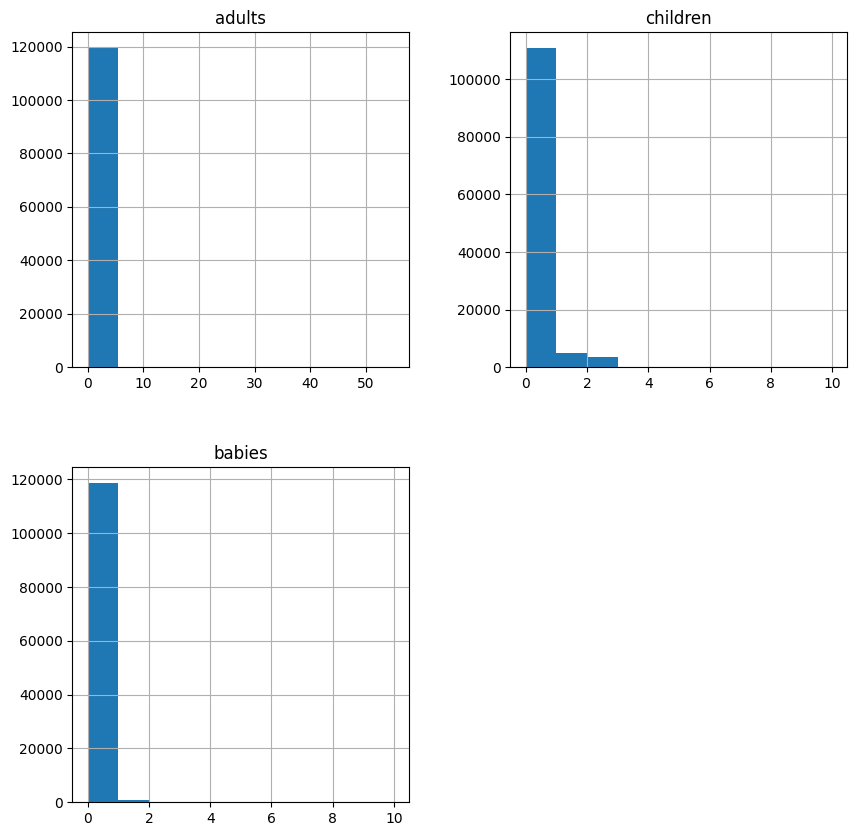

In [7]:
stays = data[['adults', 'children', 'babies']].copy()

stays.hist(bins = 10, figsize=(10,10))
plt.show()

2. Matrice de corelație pentru vizualizarea datelor

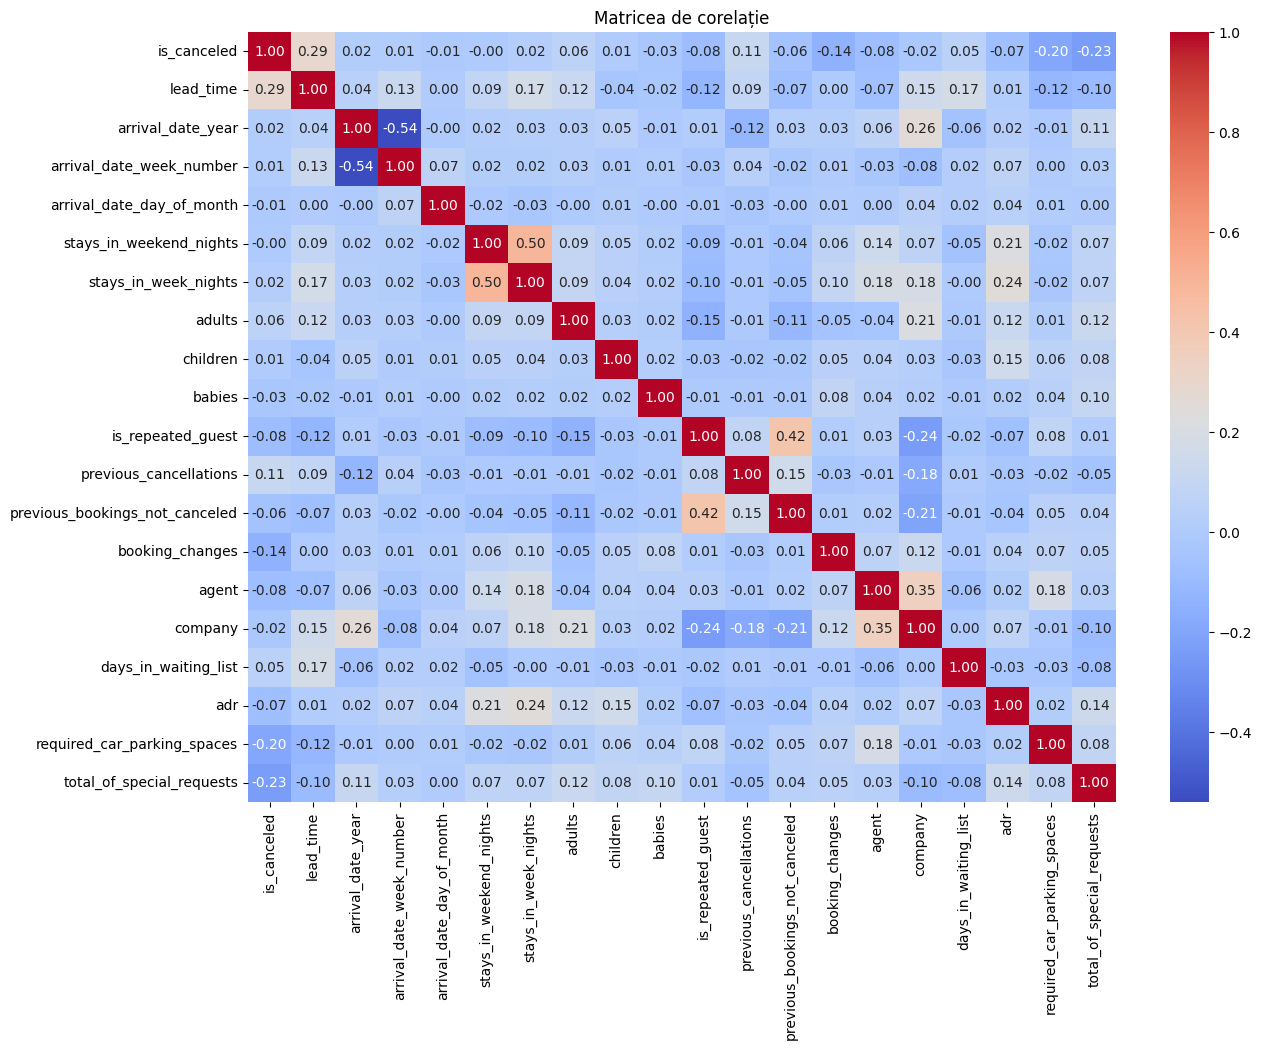

In [8]:
# Selectez doar coloanele care sunt de tip int sau float
numeric_c = data.select_dtypes(include=['int64', 'float64']).columns

# Calculăm matricea de corelație
correlation_matrix = data[numeric_c].corr()

# Vizualizăm matricea de corelație utilizând seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matricea de corelație')
plt.show()


3. Pie Chart pentru procentajul rezervărilor anulate


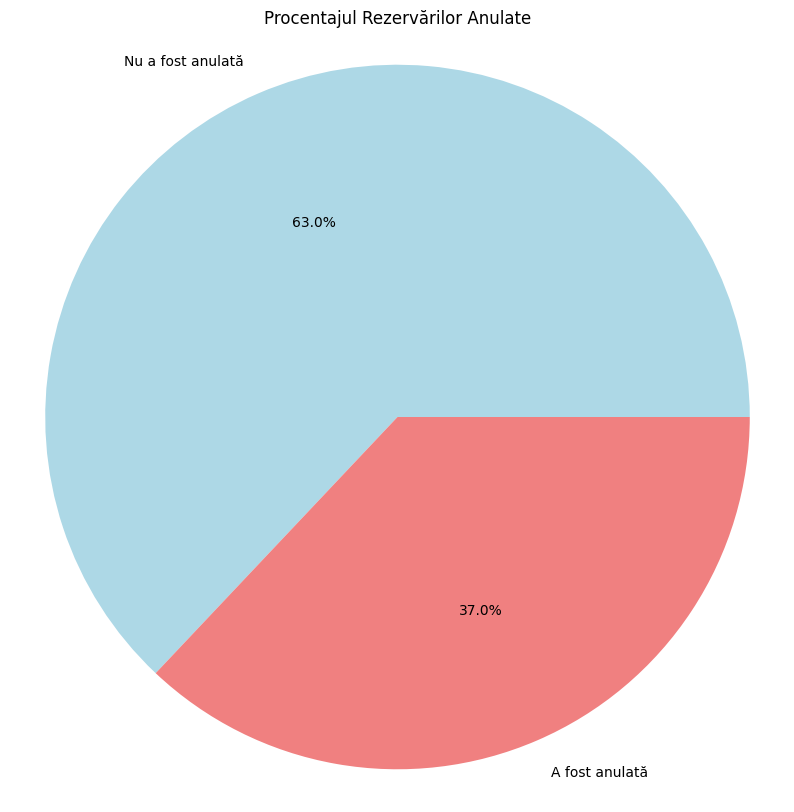

In [9]:
# Cream lista cu valorile din coloana 'is_canceled'
canceled_list = data['is_canceled'].tolist()

# Extragem valorile unice și calculăm frecvența fiecărei valori
unique_canceled = list(set(canceled_list))
pie_data_canceled = [canceled_list.count(canceled) for canceled in unique_canceled]

# Definim etichetele
labels_canceled = ['Nu a fost anulată', 'A fost anulată']

# Cream graficul de tip pie chart
plt.figure(figsize=(10, 10))
plt.pie(pie_data_canceled, labels=labels_canceled, autopct="%1.1f%%", colors=['lightblue', 'lightcoral'])

plt.title("Procentajul Rezervărilor Anulate")
plt.axis("equal")
plt.show()


4. Graficul de tip linie pentru relația dintre lead_time și is_canceled

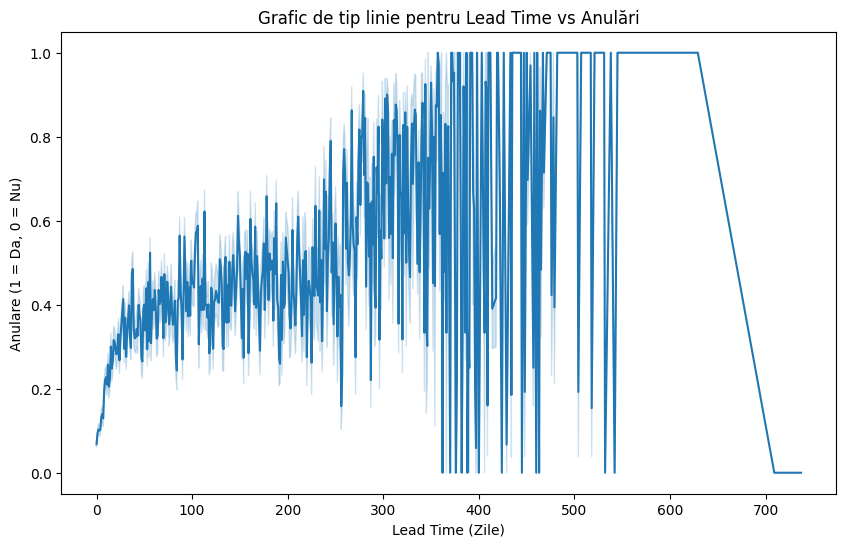

In [10]:
# Cream graficul de tip linie pentru relația dintre lead_time și is_canceled
plt.figure(figsize=(10, 6))
sns.lineplot(x='lead_time', y='is_canceled', data=data)
plt.title('Grafic de tip linie pentru Lead Time vs Anulări')
plt.xlabel('Lead Time (Zile)')
plt.ylabel('Anulare (1 = Da, 0 = Nu)')
plt.show()


# III. Preprocesarea datelor de intrare



1. Eliminarea datelor care nu sunt folositoare și tratarea valorilor lipsă

In [11]:
#pregatire pentru data clean
data_cleaned = data.copy()
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [12]:
#eliminarea coloanelor nefolositoare pentru predictia dorita
data_cleaned.drop(['arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month','meal','market_segment','reserved_room_type','assigned_room_type','agent','company','adr','required_car_parking_spaces','total_of_special_requests','reservation_status','reservation_status_date'],axis=1, inplace = True)
data_cleaned



,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type
0,Resort Hotel,0,342,0,0,2,0.0,0,PRT,Direct,0,0,0,3,No Deposit,0,Transient
1,Resort Hotel,0,737,0,0,2,0.0,0,PRT,Direct,0,0,0,4,No Deposit,0,Transient
2,Resort Hotel,0,7,0,1,1,0.0,0,GBR,Direct,0,0,0,0,No Deposit,0,Transient
3,Resort Hotel,0,13,0,1,1,0.0,0,GBR,Corporate,0,0,0,0,No Deposit,0,Transient
4,Resort Hotel,0,14,0,2,2,0.0,0,GBR,TA/TO,0,0,0,0,No Deposit,0,Transient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2,5,2,0.0,0,BEL,TA/TO,0,0,0,0,No Deposit,0,Transient
119386,City Hotel,0,102,2,5,3,0.0,0,FRA,TA/TO,0,0,0,0,No Deposit,0,Transient
119387,City Hotel,0,34,2,5,2,0.0,0,DEU,TA/TO,0,0,0,0,No Deposit,0,Transient
119388,City Hotel,0,109,2,5,2,0.0,0,GBR,TA/TO,0,0,0,0,No Deposit,0,Transient


In [13]:
coloane_categorii = data_cleaned.select_dtypes(include=['object','category']).columns
coloane_numerice = data_cleaned.select_dtypes(include=['float64','int64']).columns

for col in coloane_categorii:
    mode = data_cleaned[col].mode()[0]
    data_cleaned[col].fillna(mode, inplace=True)

for col in coloane_numerice:
    mean = data_cleaned[col].mean()
    data_cleaned[col].fillna(mean, inplace=True)


In [14]:
print("Valorile lipsa ramase dupa inlocuire sunt:")
print(data_cleaned.isna().sum())

Valorile lipsa ramase dupa inlocuire sunt:
hotel                             0
is_canceled                       0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
dtype: int64


In [15]:
x_tr = data_cleaned.drop(['is_canceled'],axis=1)
y_tr = data_cleaned['is_canceled']

labelEncoder = LabelEncoder()
for i in coloane_categorii:
  x_tr[i] = labelEncoder.fit_transform(x_tr[i])
  print(i)
print(x_tr)

hotel
country
distribution_channel
deposit_type
customer_type
        hotel  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
0           1        342                        0                     0   
1           1        737                        0                     0   
2           1          7                        0                     1   
3           1         13                        0                     1   
4           1         14                        0                     2   
...       ...        ...                      ...                   ...   
119385      0         23                        2                     5   
119386      0        102                        2                     5   
119387      0         34                        2                     5   
119388      0        109                        2                     5   
119389      0        205                        2                     7   

        adults  children  babies  cou

2. Împărțirea datelor în seturi de antrenament și seturi de testare

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)


# IV. Algoritmi Machine Learning




1. Regresie liniara

Mean Squared Error: 0.1646433058203299
R^2 Score: 0.2980456573512812
[-0.03984869  0.05518351  0.01129261  0.02582314  0.01927696  0.02412399
 -0.00662349  0.0883921   0.04019215 -0.01402683  0.0229574  -0.00944088
 -0.04041506  0.16388322 -0.01229289 -0.0135131 ]


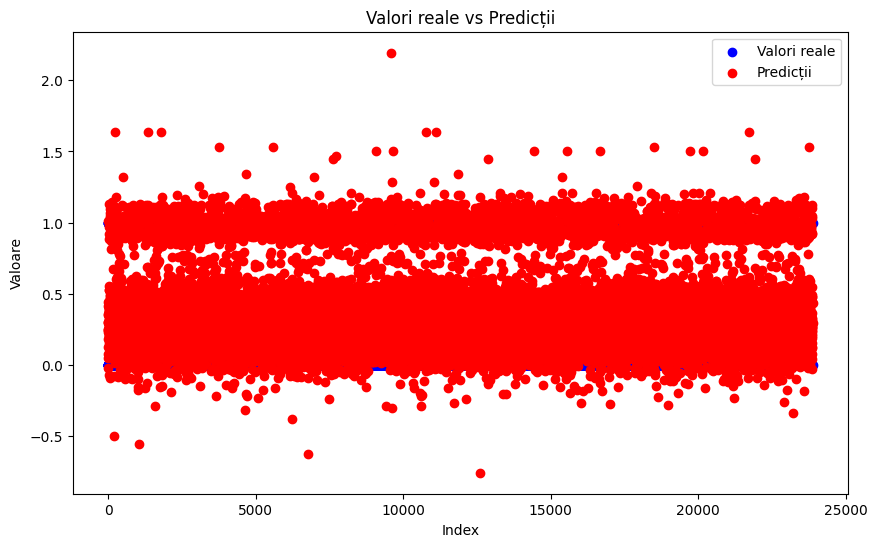

In [17]:
# Standardizarea datelor
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Antrenarea modelului de regresie liniară
model = LinearRegression()
model.fit(x_train, y_train)

# Predictii pe setul de testare
y_pred = model.predict(x_test)

# Evaluarea modelului
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

print(model.coef_)

# Vizualizarea rezultatelor cu culori diferite
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valori reale')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Predicții')
plt.xlabel("Index")
plt.ylabel("Valoare")
plt.title("Valori reale vs Predicții")
plt.legend()
plt.show()

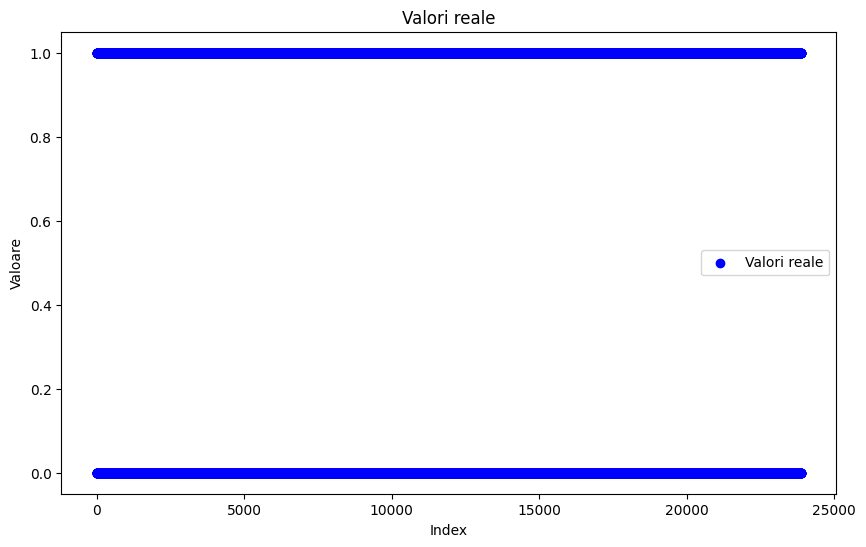

In [18]:
# Vizualizarea rezultatelor cu culori diferite
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valori reale')
plt.xlabel("Index")
plt.ylabel("Valoare")
plt.title("Valori reale")
plt.legend()
plt.show()

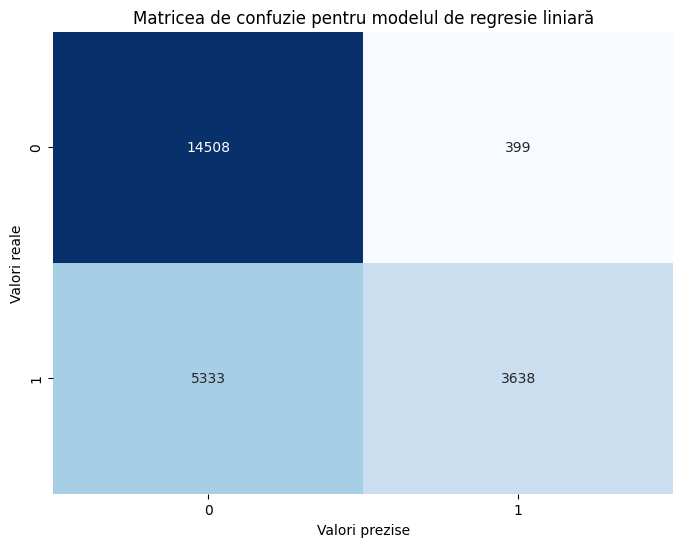

In [19]:
# Convertim predicțiile în clase binare folosind un prag de decizie (de exemplu, 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculăm matricea de confuzie
conf_matrix_lr = confusion_matrix(y_test, y_pred_binary)

# Afișăm matricea de confuzie
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Valori prezise')
plt.ylabel('Valori reale')
plt.title('Matricea de confuzie pentru modelul de regresie liniară')
plt.show()

2. Random Forest

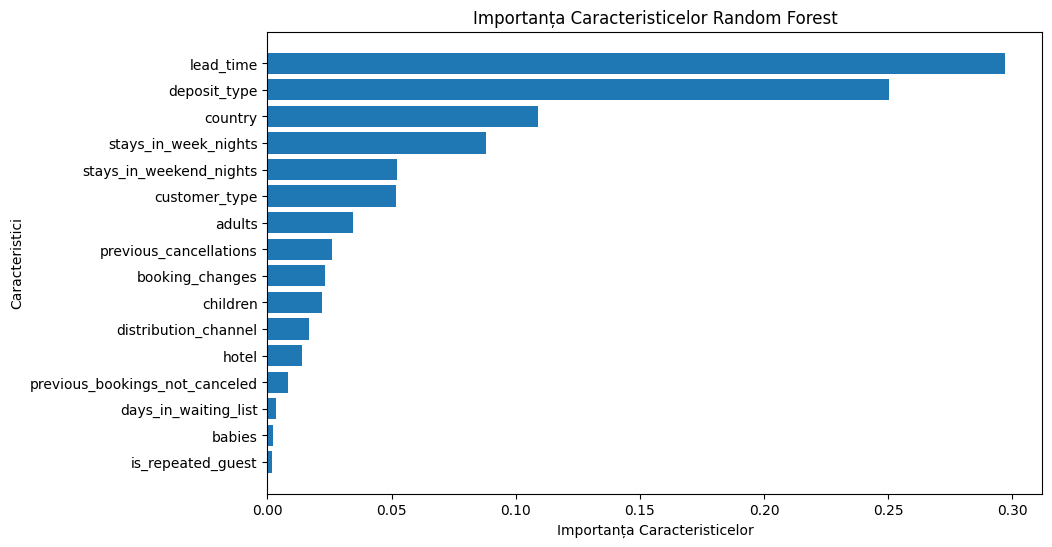

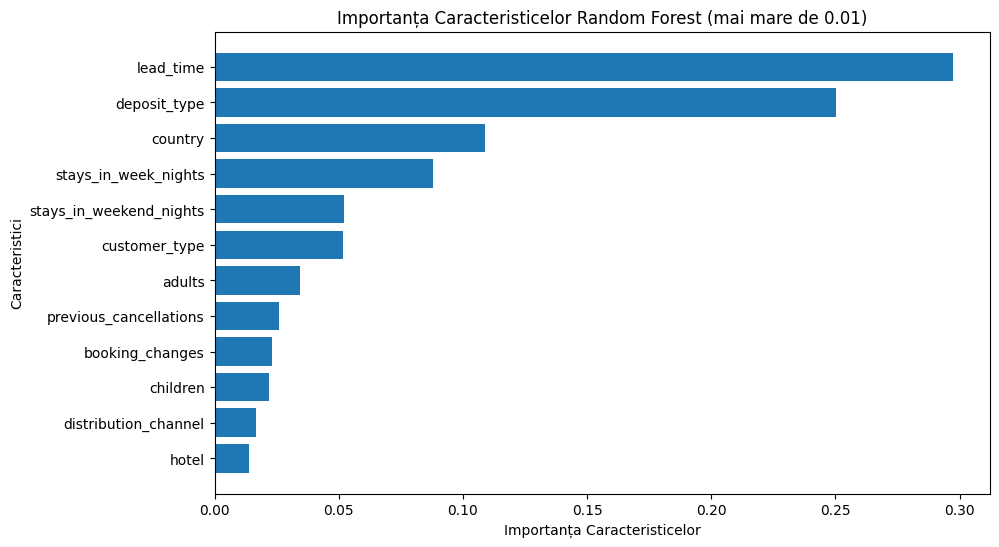

RMSE:  0.37059522162554903


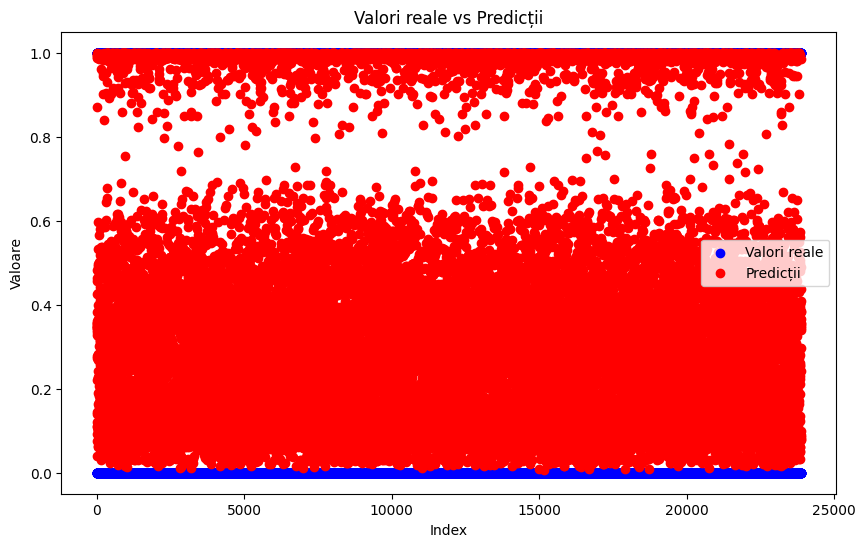

In [20]:
# Inițializăm un model de regresie Random Forest cu 100 de arbori de decizie
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Antrenăm modelul Random Forest
rf_regressor.fit(x_train, y_train)

# Obținem importanța caracteristicilor
importanta_caracteristicilor_rf = rf_regressor.feature_importances_

# Obținem indicii caracteristicilor sortate după importanță
sorted_indices_rf = importanta_caracteristicilor_rf.argsort()

# Afișăm importanța caracteristicilor
plt.figure(figsize=(10, 6))
plt.barh(range(x_train.shape[1]), importanta_caracteristicilor_rf[sorted_indices_rf], align='center')
plt.yticks(range(x_train.shape[1]), x_tr.columns[sorted_indices_rf])
plt.xlabel('Importanța Caracteristicelor')
plt.ylabel('Caracteristici')
plt.title('Importanța Caracteristicelor Random Forest')
plt.show()

# Filtrăm caracteristicile cu importanță mai mare de 0.01
selected_indices_rf = sorted_indices_rf[importanta_caracteristicilor_rf[sorted_indices_rf] > 0.01]
selected_importances_rf = importanta_caracteristicilor_rf[selected_indices_rf]

# Afișăm importanța caracteristicilor pentru cele selectate
plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_indices_rf)), selected_importances_rf, align='center')
plt.yticks(range(len(selected_indices_rf)), x_tr.columns[selected_indices_rf])
plt.xlabel('Importanța Caracteristicelor')
plt.ylabel('Caracteristici')
plt.title('Importanța Caracteristicelor Random Forest (mai mare de 0.01)')
plt.show()

# Filtrarea caracteristicilor relevante
X = x_tr.iloc[:, selected_indices_rf]
X_train, X_test, Y_train, Y_test = train_test_split(X, y_tr, test_size=0.2, random_state=5)

# Inițializăm un nou model RandomForestRegressor cu parametrii specificați
model2 = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=9, random_state=42)

# Antrenăm noul model RandomForestRegressor pe setul de date de antrenament
model2.fit(X_train, Y_train)

# Realizăm predicții pe setul de date de test folosind modelul RandomForestRegressor antrenat anterior
Y_pred = model2.predict(X_test)

# Calculăm rădăcina erorii medie pătratice (RMSE) între valorile reale și predicțiile modelului
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

# Afișăm valoarea RMSE pentru evaluarea performanței modelului
print('RMSE: ', rmse)

# Vizualizarea valorilor reale vs predicții
plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Valori reale')
plt.scatter(range(len(Y_test)), Y_pred, color='red', label='Predicții')
plt.xlabel("Index")
plt.ylabel("Valoare")
plt.title("Valori reale vs Predicții")
plt.legend()
plt.show()

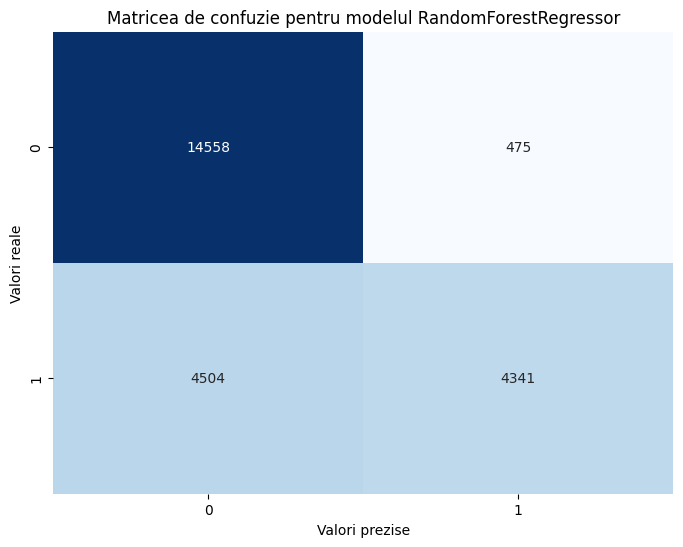

In [21]:
# Convertim predicțiile în clase binare folosind un prag de decizie (de exemplu, 0.5)
y_pred_binary_rf = (Y_pred >= 0.5).astype(int)

# Calculăm matricea de confuzie
conf_matrix_rf = confusion_matrix(Y_test, y_pred_binary_rf)

# Afișăm matricea de confuzie
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Valori prezise')
plt.ylabel('Valori reale')
plt.title('Matricea de confuzie pentru modelul RandomForestRegressor')
plt.show()

3. SVM Regressor

Eroarea pătratică medie a modelului SVM: 0.246


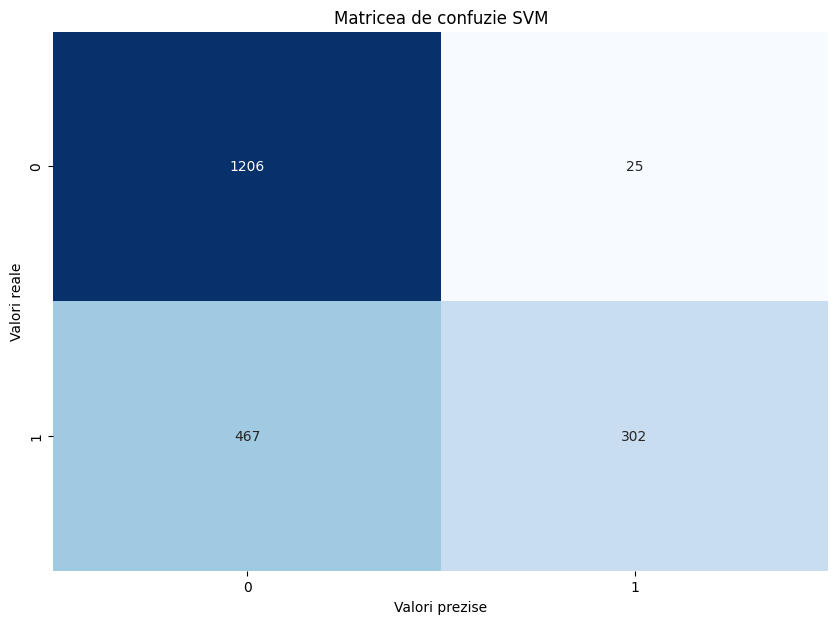

Raportul de clasificare:
               precision    recall  f1-score   support

           0       0.72      0.98      0.83      1231
           1       0.92      0.39      0.55       769

    accuracy                           0.75      2000
   macro avg       0.82      0.69      0.69      2000
weighted avg       0.80      0.75      0.72      2000

Acuratețea modelului SVM: 75.40%


In [22]:
# Preluăm un eșantion de 10,000 de linii
sampled_data = data_cleaned.sample(n=10000, random_state=42)

# Transformăm variabilele categorice în variabile numerice folosind get_dummies
sampled_data_encoded = pd.get_dummies(sampled_data, drop_first=True)

# Definirea caracteristicilor (X) și a țintei (y)
X = sampled_data_encoded.drop('is_canceled', axis=1)
y = sampled_data_encoded['is_canceled']

# Împărțirea setului de date în seturi de antrenament și test
x_t, x_tt, y_t, y_tt = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizarea caracteristicilor
scaler = StandardScaler()
x_t = scaler.fit_transform(x_t)
x_tt = scaler.transform(x_tt)

# Inițializăm și antrenăm modelul SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(x_t, y_t)

# Realizăm predicții pe setul de test
y_pred = svm_model.predict(x_tt)

mse = mean_squared_error(y_tt, y_pred)

print("Eroarea pătratică medie a modelului SVM:", mse)

# Afișăm matricea de confuzie
conf_matrix = confusion_matrix(y_tt, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Valori prezise')
plt.ylabel('Valori reale')
plt.title('Matricea de confuzie SVM')
plt.show()

# Afișăm raportul de clasificare
print("Raportul de clasificare:\n", classification_report(y_tt, y_pred))

# Calculăm și afișăm acuratețea
accuracy = accuracy_score(y_tt, y_pred)
print("Acuratețea modelului SVM: {:.2f}%".format(accuracy * 100))


# V. Algoritmi Deep Learning

1. Algoritmul ANN

In [23]:
# Standardizarea datelor
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Definirea modelului
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)
print(model)

# Antrenarea modelului
loss_fn = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 10

# Lista pentru a stoca istoricul pierderilor
loss_history = []

for epoch in range(n_epochs):
    for i in range(0, len(x_train), batch_size):
        Xbatch = torch.tensor(x_train[i:i+batch_size], dtype=torch.float32)
        y_pred = model(Xbatch)
        ybatch = torch.tensor(y_train[i:i+batch_size].values.reshape(-1, 1), dtype=torch.float32)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())
    print(f'Finished epoch {epoch}, latest loss {loss}')

# Calcularea acurateței
with torch.no_grad():
    Xtest = torch.tensor(x_test, dtype=torch.float32)
    y_pred = model(Xtest)

accuracy = ((y_pred.round() == torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)).float().mean()) * 100
print(f"Accuracy {accuracy}%")

Sequential(
  (0): Linear(in_features=16, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)
Finished epoch 0, latest loss 0.41139817237854004
Finished epoch 1, latest loss 0.41086941957473755
Finished epoch 2, latest loss 0.4252488613128662
Finished epoch 3, latest loss 0.44985273480415344
Finished epoch 4, latest loss 0.41283994913101196
Finished epoch 5, latest loss 0.40304338932037354
Finished epoch 6, latest loss 0.3976752758026123
Finished epoch 7, latest loss 0.41566768288612366
Finished epoch 8, latest loss 0.3939703702926636
Finished epoch 9, latest loss 0.39297157526016235
Finished epoch 10, latest loss 0.38299015164375305
Finished epoch 11, latest loss 0.3724898397922516
Finished epoch 12, latest loss 0.36897674202919006
Finished epoch 13, latest loss 0.367843359708786
Finished epoch 14, latest loss 0.36718088388442993
Finished epoch 15, la

MSE: 0.13310272991657257


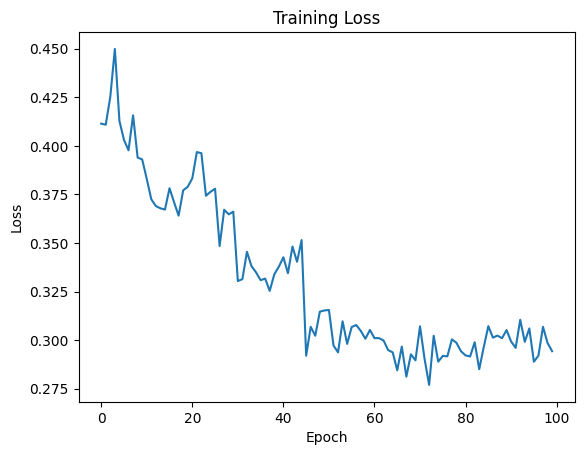

In [24]:
# Calcularea erorii
mse = nn.MSELoss()
error = mse(y_pred, torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)).item()
print(f"MSE: {error}")

# Afisarea graficului cu istoricul pierderilor
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

2. Algoritmul CNN

Finished epoch 0, latest loss 0.17504625022411346
Finished epoch 1, latest loss 0.16893872618675232
Finished epoch 2, latest loss 0.17087465524673462
Finished epoch 3, latest loss 0.16288016736507416
Finished epoch 4, latest loss 0.1648990362882614
Finished epoch 5, latest loss 0.1606014519929886
Finished epoch 6, latest loss 0.16078196465969086
Finished epoch 7, latest loss 0.1621222048997879
Finished epoch 8, latest loss 0.16096922755241394
Finished epoch 9, latest loss 0.15662044286727905
Finished epoch 10, latest loss 0.15851978957653046
Finished epoch 11, latest loss 0.1553792655467987
Finished epoch 12, latest loss 0.15596996247768402
Finished epoch 13, latest loss 0.15120254456996918
Finished epoch 14, latest loss 0.15444940328598022
Finished epoch 15, latest loss 0.14926865696907043
Finished epoch 16, latest loss 0.15217772126197815
Finished epoch 17, latest loss 0.1518588811159134
Finished epoch 18, latest loss 0.15300574898719788
Finished epoch 19, latest loss 0.1501373201608

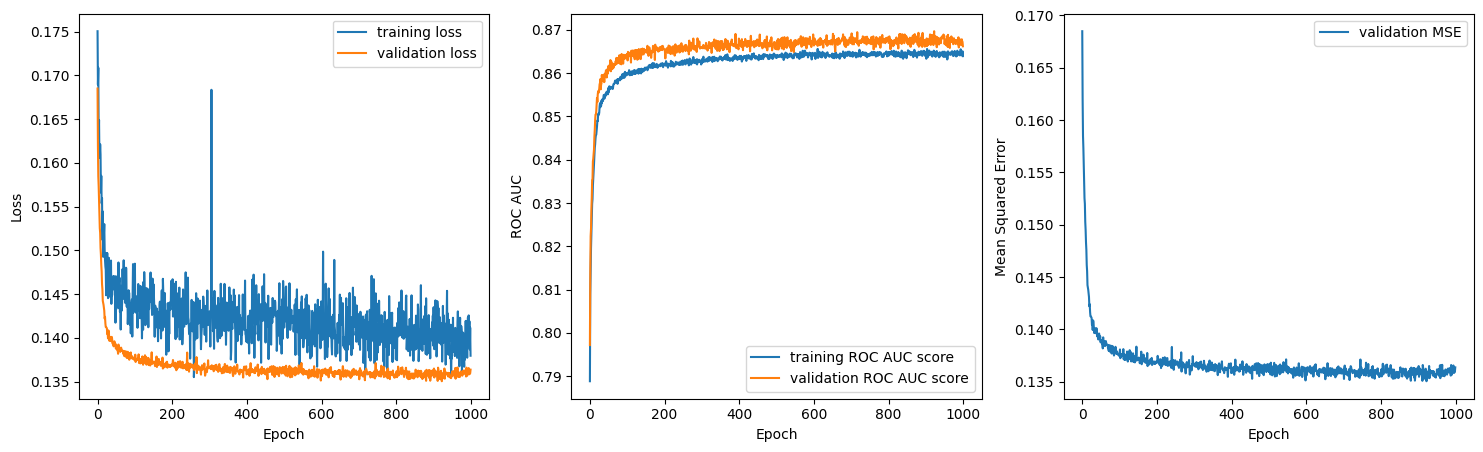

In [25]:
# Definirea setului de date și prelucrarea acestuia
# Să presupunem că X_train, X_val, y_train și y_val sunt deja definite

# Standardizarea datelor
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_val = scaler.transform(x_test)

# Definirea modelului
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 27),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(27, 9),
    nn.ReLU(),
    nn.Linear(9, 1)
)

# Definirea optimizatorului și funcției de pierdere
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Antrenarea modelului
n_epochs = 1000
batch_size = 1000

history = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': [], 'error': []}

for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
        y_batch = torch.tensor(y_train[i:i+batch_size].values.reshape(-1, 1), dtype=torch.float32).reshape(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

    # Calcularea metricilor pe setul de validare
    with torch.no_grad():
        y_pred_val = model(torch.tensor(X_val, dtype=torch.float32))
        val_loss = loss_fn(y_pred_val, torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32))

    history['loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    # Metrica AUC nu este direct disponibilă în PyTorch, deci trebuie calculată manual
    auc_train = roc_auc_score(y_train, model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy())
    auc_val = roc_auc_score(y_test, y_pred_val.detach().numpy())
    history['auc'].append(auc_train)
    history['val_auc'].append(auc_val)

     # Calcularea erorii pe setul de validare
    error = mean_squared_error(y_test, y_pred_val.detach().numpy())
    history['error'].append(error)

# Vizualizarea evoluției pierderilor, a AUC-urilor și a erorii pe parcursul antrenării
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history['auc'], label='training ROC AUC score')
plt.plot(history['val_auc'], label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.subplot(1, 3, 3)
plt.plot(history['error'], label='validation MSE')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()
